In [ ]:
import cv2
import os
from PIL import Image
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
image_directory = 'datasets/'
no_tumor_img = os.listdir(image_directory + 'no')
yes_tumor_img = os.listdir(image_directory + 'yes')
dataset = []
label = []
INPUT_SIZE = 64

In [ ]:
for i, image_name in enumerate(no_tumor_img):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(image_directory + 'no/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i, image_name in enumerate(yes_tumor_img):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(image_directory + 'yes/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [ ]:
dataset = np.array(dataset)
label = np.array(label)
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [ ]:
x_train = Rescaling(scale=1./255, offset=0.0)(x_train)
x_test = Rescaling(scale=1./255, offset=0.0)(x_test)

In [ ]:
new_model = Sequential()                                                               # defining the model instance in keras
new_model.add(ResNet50(include_top = False, input_shape = (64,64,3), classes = 2))     # inbuilt resnet weights from ImageNet
new_model.add(Flatten())                                                               # flatenning the resnet output
new_model.add(Dense(1, activation = 'sigmoid'))                                        # the last sigmoid layer with one node for classification


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
new_model.compile(
    loss = 'binary_crossentropy',      # loss function
    optimizer = 'adam',                # optimizer
    metrics = ['accuracy']             # report accuracy during training
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience=4, mode='min')

In [ ]:
hist = new_model.fit(x_train, y_train, batch_size=16, verbose=1, epochs=10, validation_data=(x_test, y_test), shuffle=False, callbacks = [early_stopping])

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.9917 - loss: 0.0186 - val_accuracy: 0.9333 - val_loss: 0.2862
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.9955 - loss: 0.0137 - val_accuracy: 0.9350 - val_loss: 0.3479
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.9968 - loss: 0.0119 - val_accuracy: 0.9733 - val_loss: 0.1840
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9940 - loss: 0.0261 - val_accuracy: 0.9783 - val_loss: 0.1042
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.9922 - loss: 0.0222 - val_accuracy: 0.9700 - val_loss: 0.1556
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9960 - loss: 0.0107 - val_accuracy: 0.9733 - val_loss: 0.1916
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.9938 - loss: 0.0160 - val_accuracy: 0.9600 - val_loss: 0.1171
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.9964 - loss: 0.0110 - val_accu

In [ ]:
#Plotting the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

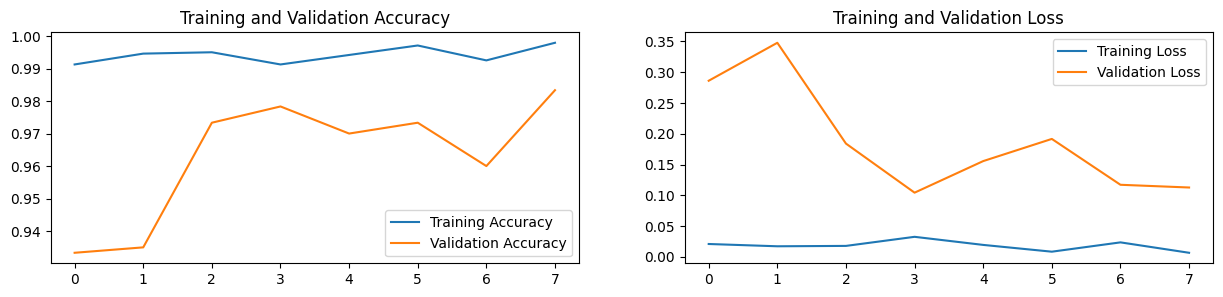

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc= "upper right")
plt.title("Training and Validation Loss")

In [ ]:
loss,acc = new_model.evaluate(x_test,y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.9889 - loss: 0.0832


In [ ]:
from sklearn.metrics import f1_score
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [ ]:
y_test_prob = new_model.predict(x_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step
F1 score: 0.9803149606299213


In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Assuming `y_true` contains true labels and `y_pred` contains predicted probabilities or labels
y_true = y_test
y_pred = new_model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Threshold to get class labels

precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 641ms/step
Precision: 0.9920318725099602
Recall: 0.9688715953307393
AUC-ROC: 0.9924901589318329


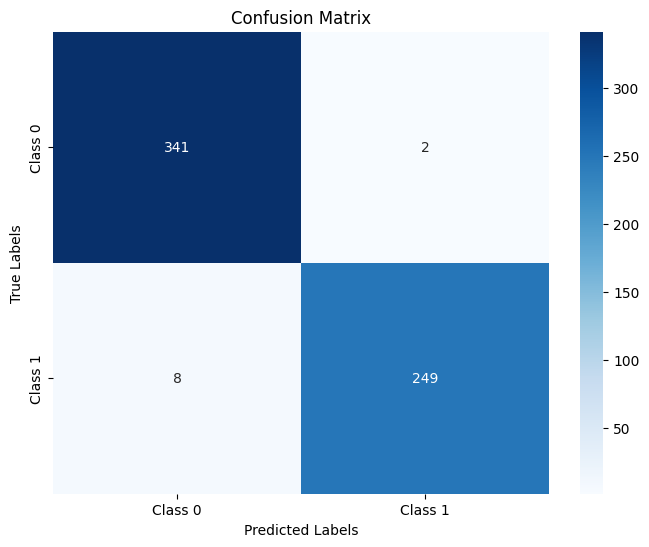

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_labels = (y_pred > 0.5).astype(int)
# Assuming `y_true` contains true labels and `y_pred_labels` contains predicted class labels
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Alternatively, using seaborn for customization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


**OUR MODEL**


In [ ]:
model = Sequential()

model.add(Conv2D(32,(3, 3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train, y_train, batch_size=16, verbose=1, epochs=10, validation_data=(x_test, y_test), shuffle=False)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.9969 - loss: 0.0136 - val_accuracy: 0.9700 - val_loss: 0.1742
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9979 - loss: 0.0090 - val_accuracy: 0.9683 - val_loss: 0.1960
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9978 - loss: 0.0042 - val_accuracy: 0.9767 - val_loss: 0.2413
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 1.0000 - loss: 3.8594e-04 - val_accuracy: 0.9733 - val_loss: 0.2749
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 1.0000 - loss: 3.3134e-04 - val_accuracy: 0.9800 - val_loss: 0.2663
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 1.0000 - loss: 3.6764e-04 - val_accuracy: 0.9750 - val_loss: 0.2844
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9500 - val_loss: 0.3251
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9868 - los

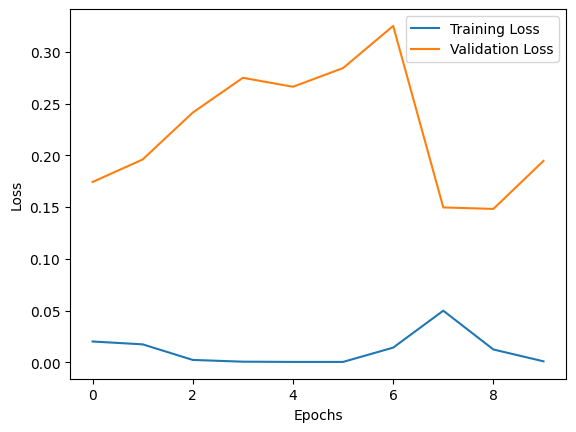

In [ ]:
#Plotting the results
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

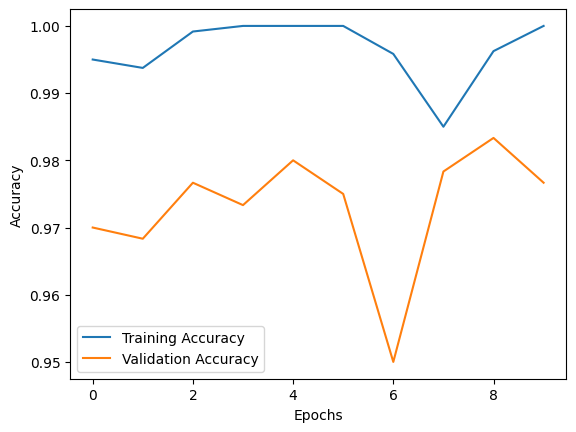

In [ ]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
print("The model is being evaluated")
test_loss, test_acc = model.evaluate(x_test, y_test)
print("The accuracy of the model is:")
print(test_acc)
print("Test loss is:")
print(test_loss)

The model is being evaluated
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9806 - loss: 0.1443
The accuracy of the model is:
0.9766666889190674
Test loss is:
0.194645494222641


In [ ]:
from sklearn.metrics import f1_score
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [ ]:
y_test_prob = model.predict(x_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
F1 score: 0.9725490196078431


In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Assuming `y_true` contains true labels and `y_pred` contains predicted probabilities or labels
y_true = y_test
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Threshold to get class labels

precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Precision: 0.9802371541501976
Recall: 0.9649805447470817
AUC-ROC: 0.9909360075325294


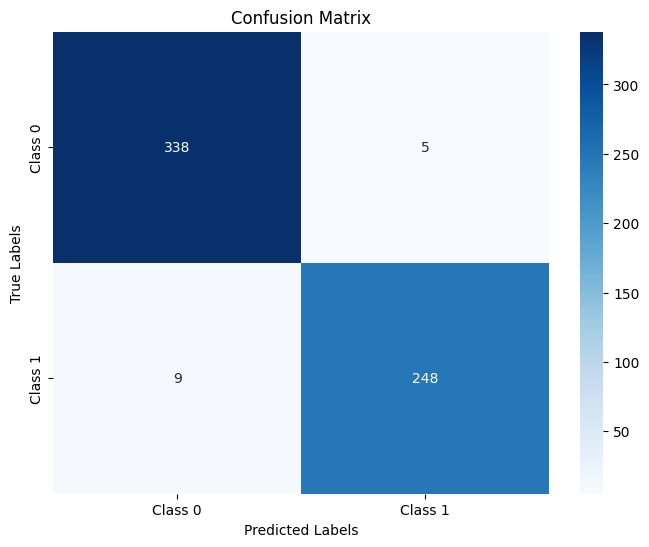

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_labels = (y_pred > 0.5).astype(int)
# Assuming `y_true` contains true labels and `y_pred_labels` contains predicted class labels
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Alternatively, using seaborn for customization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from keras.applications import VGG16
new_model = Sequential()                                                               # defining the model instance in keras
new_model.add(VGG16(include_top = False, input_shape = (64,64,3), classes = 2))        # inbuilt vgg16 weights from ImageNet
new_model.add(Flatten())                                                               # flatenning the resnet output
new_model.add(Dense(1, activation = 'sigmoid'))                                        # the last sigmoid layer with one node for classification


In [ ]:
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = new_model.fit(x_train, y_train, batch_size=16, verbose=1, epochs=10, validation_data=(x_test, y_test), shuffle=False)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.5272 - loss: 1.2510 - val_accuracy: 0.5117 - val_loss: 0.6899
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.5832 - loss: 0.6707 - val_accuracy: 0.7217 - val_loss: 0.5709
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.7188 - loss: 0.5777 - val_accuracy: 0.7167 - val_loss: 0.5901
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.7423 - loss: 0.5293 - val_accuracy: 0.7617 - val_loss: 0.6450
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.7923 - loss: 0.4877 - val_accuracy: 0.8333 - val_loss: 0.3966
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.8429 - loss: 0.3739 - val_accuracy: 0.8850 - val_loss: 0.3103
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.8888 - loss: 0.2883 - val_accuracy: 0.8700 - val_loss: 0.3165
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.9055 - loss: 0.2325 - val_accu

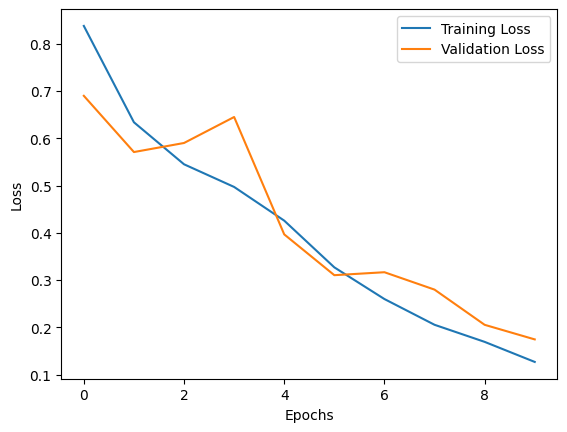

In [ ]:
#Plotting the results
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

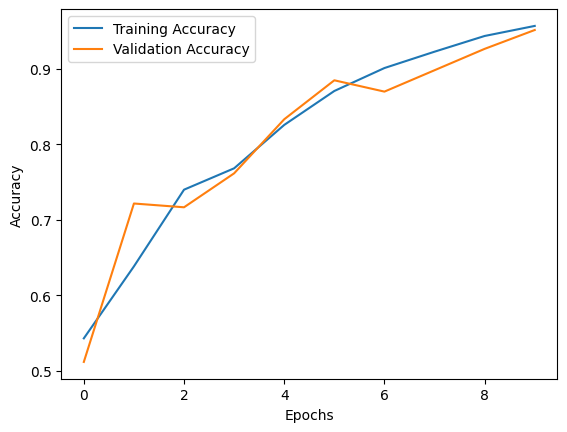

In [ ]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print("The model is being evaluated")
test_loss, test_acc = new_model.evaluate(x_test, y_test)
print("The accuracy of the model is:")
print(test_acc)
print("Test loss is:")
print(test_loss)

The model is being evaluated
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9510 - loss: 0.1730
The accuracy of the model is:
0.9516666531562805
Test loss is:
0.1743782013654709


In [ ]:
y_test_prob = new_model.predict(x_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
F1 score: 0.9439071566731141


In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Assuming `y_true` contains true labels and `y_pred` contains predicted probabilities or labels
y_true = y_test
y_pred = new_model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Threshold to get class labels

precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Precision: 0.9384615384615385
Recall: 0.9494163424124513
AUC-ROC: 0.980204421957777


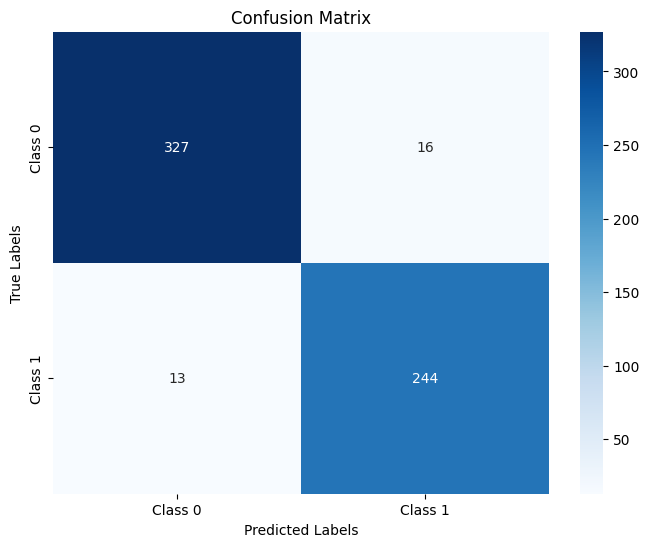

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_labels = (y_pred > 0.5).astype(int)
# Assuming `y_true` contains true labels and `y_pred_labels` contains predicted class labels
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Alternatively, using seaborn for customization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
